##**Introduction to Supervised Learning on Graphs**

Notebook References:


1.Graph Machine Learning: Take graph data to the next level by applying machine learning techniques and algorithms https://github.com/PacktPublishing/Graph-Machine-Learning

2.Jure Leskovec, Stanford CS224W: Machine Learning with Graphs, http://cs224w.stanford.edu

3.Inductive settings of GraphSAGE, dgl implementation.
https://github.com/dmlc/dgl/pull/1741/files#diff-f94a94c19e905501ba4f5f52d653608cd7359ab05411862196b34600be51d5ea

4.Graph Classification - DGL implementation https://docs.dgl.ai/guide/training-graph.html?highlight=graph%20classification

5.https://discuss.dgl.ai/t/using-edge-features-for-gcn-in-dgl/427/4

6.https://github.com/dmlc/dgl/blob/master/examples/pytorch/gin/train.py

7.Training GNN for Edge Classification with Neighborhood Sampling, https://docs.dgl.ai/guide/minibatch-edge.html?highlight=edge%20classification

8.Graph Convolutional Networks (GCN), https://github.com/dmlc/dgl/tree/master/examples/tensorflow/gcn

##**Dependincies**

In [ ]:
!pip install karateclub
!pip install node2vec
!pip install dgl
!pip install networkx==2.8.4
!pip install adjustText

*Restart runtime

##**Graph Neural Networks (GNN)**

###**Graph Convolutional Networks**

### comments from the lecture
Accuracy:  how many correct labels the model has predicted from the total number of labels

To improve accuracy, this model is not optimized, you will play with the hyperparameters

Another thing that impacts, also the output dimension of the embeddings vector for each node sometimes has a big effect on accuracy

###**GraphSAGE**

####Graph Classification

The major difference between graph classification and node classification or link prediction is that the prediction result characterizes the property of the entire input graph. One can perform the message passing over nodes/edges just like the previous tasks, but also needs to retrieve a graph-level representation.


In DGL, one can build a single batched graph from a list of graphs. This batched graph can be simply used as a single large graph, with connected components corresponding to the original small graphs.

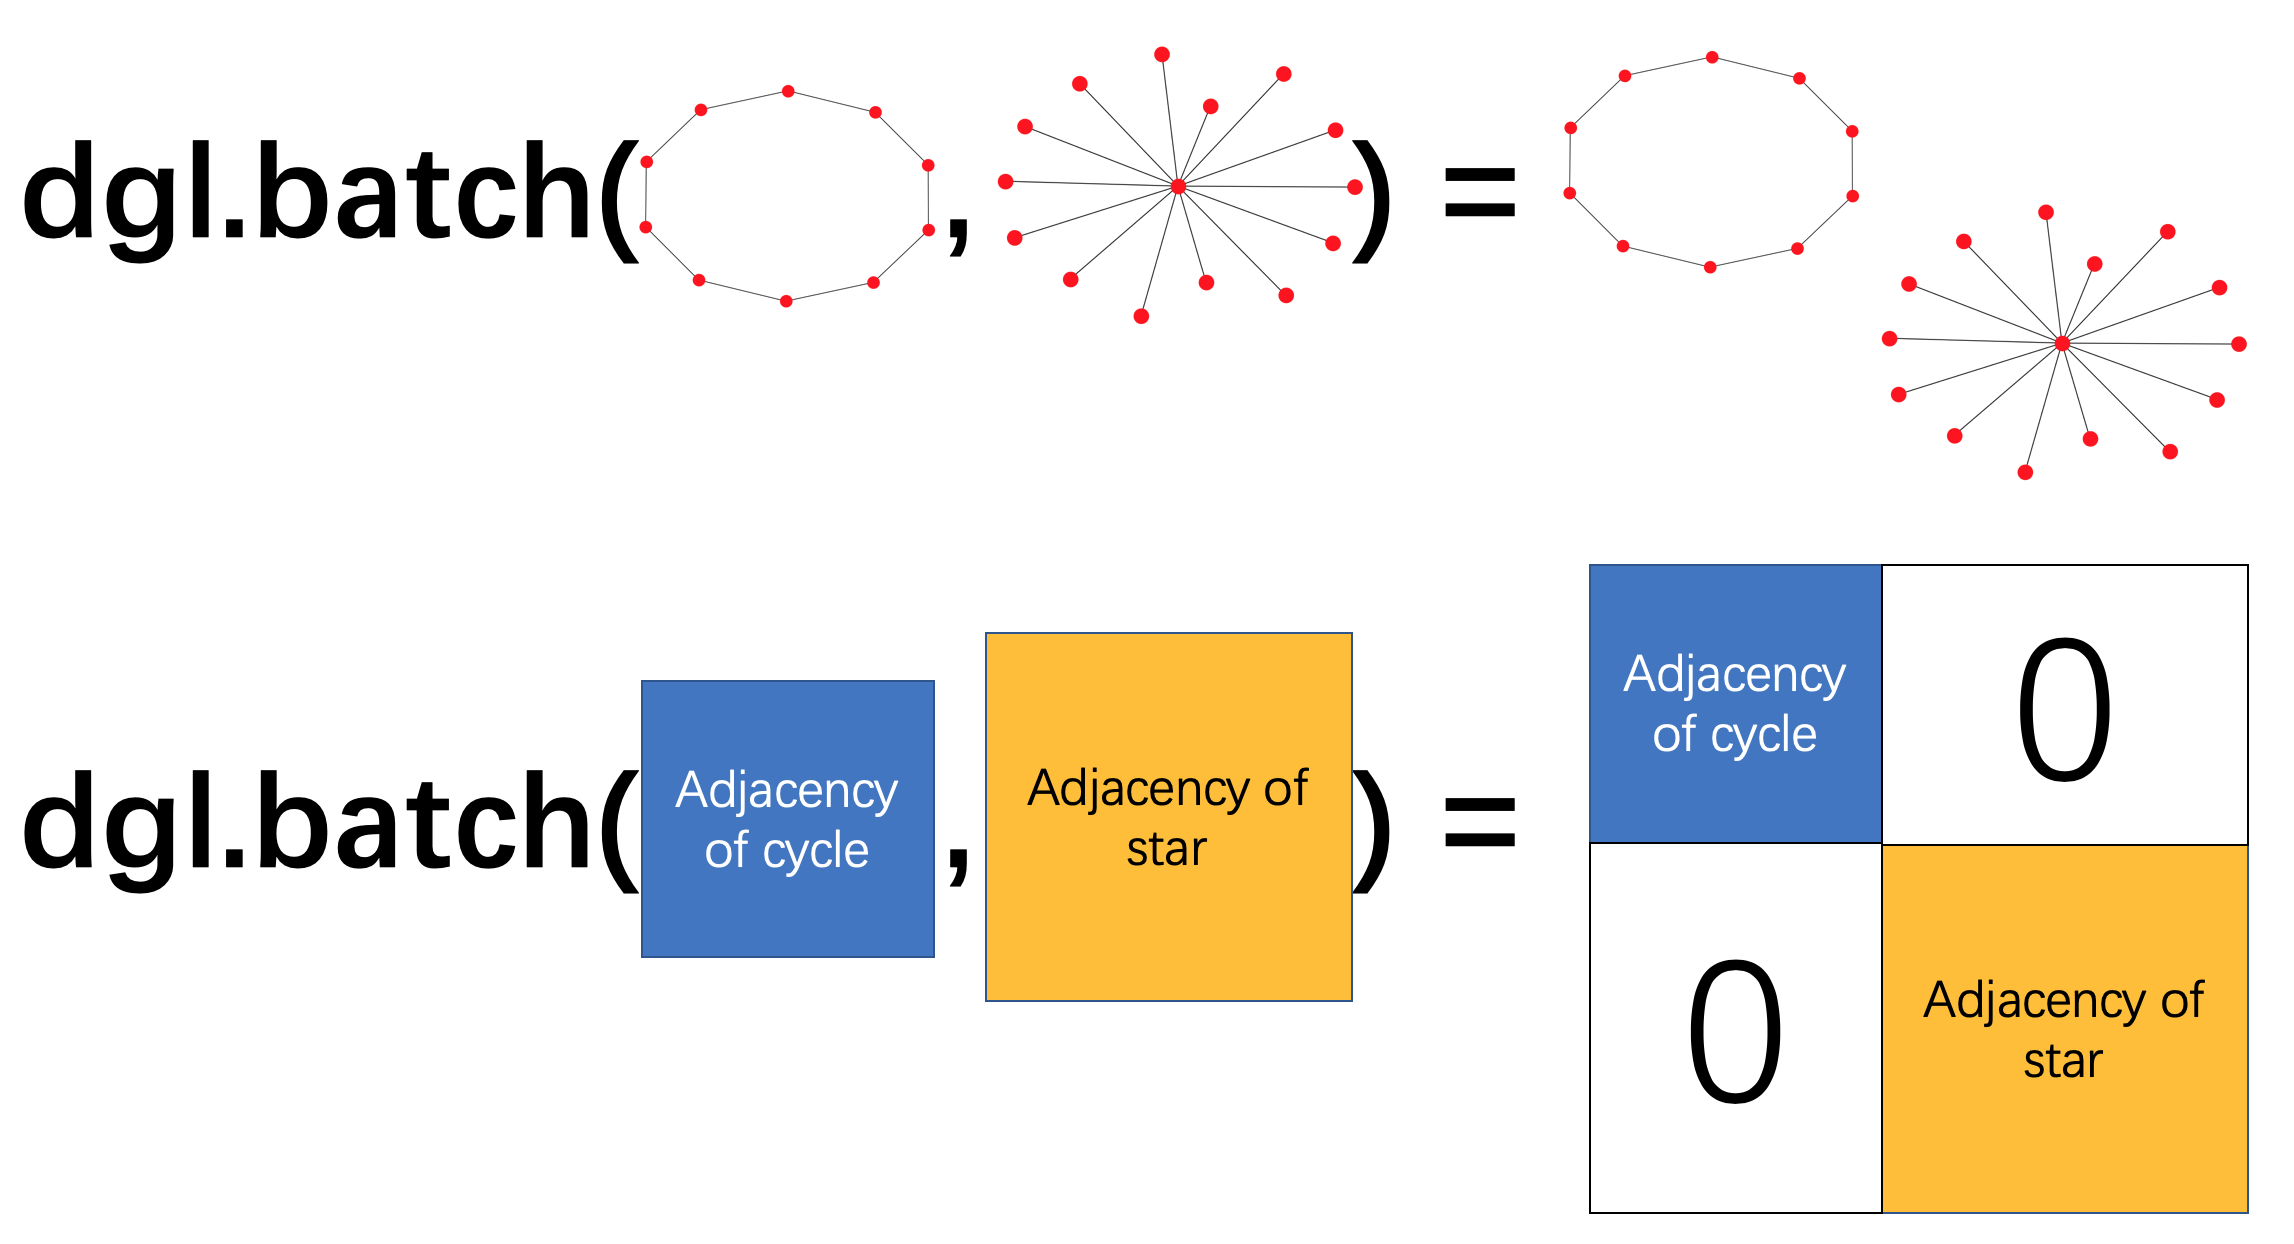

[source](https://docs.dgl.ai/guide/training-graph.html?highlight=graph%20classification)

*Notice that this is similar to what we did in the multi-graphs workflow of inductive link prediction and node classification*

---

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import dgl
from dgl.nn import GraphConv
import math
import time
from tqdm import tqdm
import copy
from collections import Counter
from __future__ import division
from __future__ import print_function
from dgl.nn import SAGEConv
import sklearn.linear_model as lm
import sklearn.metrics as skm
import itertools
import scipy.sparse as sp
import dgl.function as fn
from sklearn.metrics import roc_auc_score
import torch
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from dgl.dataloading import GraphDataLoader

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


#####**Load data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import walk
folder_path='/content/drive/MyDrive/AI_graph/FinalSubmission/Dataset/Nodes_Edges'
paths = next(walk(folder_path), (None, None, []))[2]

**If for any reason the paths names are not orderd from 1  -like the dataset location has been changed- , they must be reordered**

In [ ]:
#They must be in a correct order starting from 1
#paths

**Reorder path names**

In [ ]:
from natsort import natsorted
paths=natsorted(paths)
paths

In [ ]:
all_graphs_nodes=[]
all_graphs_edges=[]
for i in paths:
  if "nodelist.csv" in i:
    graphs_nodes=pd.read_csv(folder_path+'/'+i)
    all_graphs_nodes.append(graphs_nodes)
  elif "edgelist.csv" in i:
    graphs_edges=pd.read_csv(folder_path+'/'+i)
    all_graphs_edges.append(graphs_edges)

In [ ]:
all_graphs_nodes[5]

,x,y,z,RoomType,RoomQualit,RoomArea,RoomPrem
0,-14.144028,-5.070319,1.75,0,0.511735,86.057677,169.932243
1,9.632571,-8.060058,1.75,1,1.727026,118.841554,44.550836
2,12.680853,8.147478,1.75,1,1.726841,118.841554,44.520628
3,-14.144028,-9.633606,1.75,1,0.000000,98.351631,40.471925
4,-4.896010,-0.858054,1.75,1,0.619657,106.547600,42.500053
5,-16.669748,1.521096,1.75,1,1.071543,110.645585,42.522709
6,-1.010288,-9.633606,1.75,1,0.599851,98.351631,40.471925
7,1.515432,10.647669,1.75,1,1.095390,110.645585,42.522709
8,-7.577158,10.647669,1.75,1,1.214628,110.645585,42.522709


In [ ]:
all_graphs_edges[5]

,vi,vj,adjacency
0,0,2,9.110956e-02
1,0,6,2.000746e-01
2,0,5,3.577137e-02
3,0,8,1.788569e-01
4,0,4,9.508579e-02
5,0,7,2.384758e-01
6,0,1,9.104778e-02
7,0,3,1.672532e-16
8,1,6,2.911224e-01
9,2,7,3.295854e-01


**Load the graphs labels**

In [ ]:
labels_path='/content/drive/MyDrive/AI_graph/FinalSubmission/Dataset/Graphs/FLG.csv'
graphs_labels=pd.read_csv(labels_path , header = 0)
#graphs_labels.columns = ['PLanQualt']
graphs_labels

,PlanQualt,encoded_graph_labels
0,0.821710,1
1,0.863134,1
2,0.938339,1
3,0.933211,1
4,0.822473,1
...,...,...
1895,1.230991,3
1896,1.282888,3
1897,1.224987,3
1898,1.273345,3


In [ ]:
graphs_labels.describe()

,PlanQualt,encoded_graph_labels
count,1900.000000,1900.000000
mean,0.996220,1.500000
std,0.204879,1.118328
min,0.530967,0.000000
25%,0.800655,0.750000
50%,1.000742,1.500000
75%,1.199986,2.250000
max,1.320899,3.000000


In [ ]:
# encoded_graph_labels=[]
# for i in graphs_labels.values:
#   #print(i[0]) # each value is in a single list
#   if i[0] < 0.8:
#     encoded_graph_labels.append(0)
#   elif i[0] >=0.8 and i[0] < 1:
#     encoded_graph_labels.append(1)
#   elif i[0] >=1 and i[0] < 1.2:
#     encoded_graph_labels.append(2)
#   elif i[0] >=1.2 :
#     encoded_graph_labels.append(3)

In [ ]:
# # graphs_labels['encoded_graph_labels']=encoded_graph_labels
# # graphs_labels
# encoded_graph_labels

In [ ]:
# graphs_labels['encoded_graph_labels']=encoded_graph_labels
# graphs_labels
# graphs_labels = graphs_labels.drop(["PlanEff","PlanArea"], axis=1)

In [ ]:
graphs_labels

,PlanQualt,encoded_graph_labels
0,0.821710,1
1,0.863134,1
2,0.938339,1
3,0.933211,1
4,0.822473,1
...,...,...
1895,1.230991,3
1896,1.282888,3
1897,1.224987,3
1898,1.273345,3


In [ ]:
import pandas as pd
import seaborn as sns
import altair as alt

sns.set(rc={'figure.figsize':(10,10)})
print("imports ok")

imports ok


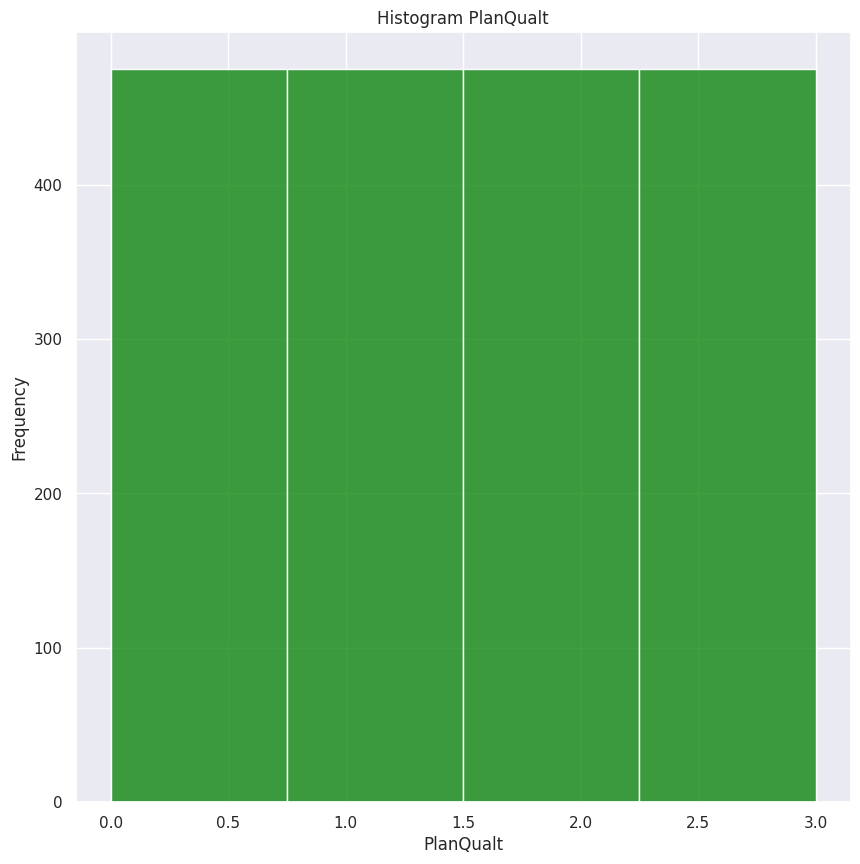

In [ ]:
sns.histplot(graphs_labels["encoded_graph_labels"], bins=4, color="Green")
plt.title("Histogram PlanQualt")
plt.xlabel("PlanQualt")
plt.ylabel("Frequency")
plt.show()

**Check the number of times each class is represented**

This is very important for classification, if for example class A represents 90% of the samples, it is very possible for the model to predict all classes as A, bacause most of the times it does, the loss function decreases. This means you can get a very heigh accuracy, yet the model didn't actually learn to classify, because of the unbalanced dataset.

In [ ]:
from collections import Counter
oc=Counter(list(graphs_labels))
oc

Counter({'PlanQualt': 1, 'encoded_graph_labels': 1})

**Check there is no empty csv (in case some variations were corrupted)**

<font color='red'>*This happend because Topologic at some seeds failed to get a cellcomplex from the input geometry*</font>

In general, when creating a big dataset, some samples may need to be removed if they are outliers, or if it is a simulation based dataset, some samples may fail and we usually need to remove them as a preprocessing step.


In [ ]:
# data_to_remove=[]
# for i in range(len(all_graphs_nodes)):
#   if len(all_graphs_nodes[i]) == 0 or len(all_graphs_edges[i]) ==0:
#     print(f'empty csv found at index {i}')
#     data_to_remove.append(i)

In [ ]:
#check
all_graphs_nodes[74]

,x,y,z,RoomType,RoomQualit,RoomArea,RoomPrem
0,10.872417,-2.631869,1.75,0,0.582323,46.168390,83.496092
1,-9.782242,-7.055112,1.75,1,1.044907,111.830100,44.652550
2,11.767793,-5.514393,1.75,1,1.395113,24.623141,20.300372
3,10.232863,4.511776,1.75,1,1.377616,110.804135,42.481961
4,-1.023286,2.506542,1.75,1,1.000000,106.700279,42.647316
5,-12.279436,4.511776,1.75,1,1.377616,110.804135,42.481961


In [ ]:
# #run only one time, it changes the original list
# for index in sorted(data_to_remove, reverse=True):  #remove them in reverse order, otherwise we will remove worng indicies in next iterations
#     del all_graphs_nodes[index]
#     del all_graphs_edges[index]

**Let's check again now**

In [ ]:
# for i in range(len(all_graphs_nodes)):
#   if len(all_graphs_nodes[i]) == 0 or len(all_graphs_edges[i]) ==0:
#     print(f'empty csv found at index {i}')

**Also remove the corresponding graph labels**

In [ ]:
# graphs_labels_list=graphs_labels.values.tolist()
# #run only one time, it changes the original list
# for index in sorted(data_to_remove, reverse=True):  #remove them in reverse order, otherwise we will remove worng indicies in next iterations
#     del graphs_labels_list[index]

In [ ]:
graphs_labels_list=graphs_labels.values.tolist()

In [ ]:
print(len(all_graphs_nodes))
print(len(all_graphs_edges))
print(len(graphs_labels))

1900
1900
1900


---

 ⭐ We will combine edge features into one decimal value per edge, this is because if we provide a **weighted graph** to the GNN layer from dgl, the edge weight will be used in the message passing function along with nodes features. If we have a vector of edge features (not just a single value per edge) , we will need in this case to change the <font color='blue'>**message function**</font>  used in the GNN layer, which means we can not directly use the built-in GNN layers like GraphConv or SAGEConv as they are.

<font color='green'>***Check reference 5 for a more detailed explaination.***</font>


In [ ]:
all_graphs_edges[5]

,vi,vj,adjacency
0,0,2,9.110956e-02
1,0,6,2.000746e-01
2,0,5,3.577137e-02
3,0,8,1.788569e-01
4,0,4,9.508579e-02
5,0,7,2.384758e-01
6,0,1,9.104778e-02
7,0,3,1.672532e-16
8,1,6,2.911224e-01
9,2,7,3.295854e-01


In [ ]:
# import math
# all_graphs_edge_weights=[]
# for graph_edges in all_graphs_edges:
#   graph_edge_weights=[]
#   for length,angle in zip(graph_edges['length'],graph_edges['angle']):
#     g_w=math.tan(math.radians(angle)) * length
#     graph_edge_weights.append(g_w)

#   all_graphs_edge_weights.append(graph_edge_weights)


In [ ]:
# #add the weight column to the dataframes
# for i in range(len(all_graphs_edges)):
#   all_graphs_edges[i]['weight']=all_graphs_edge_weights[i]

In [ ]:
# #check
# test_b=math.tan(math.radians(25.239402)) * 24.772350
# test_b

11.677797875377944

In [ ]:
#Check
all_graphs_edges[8]

,vi,vj,adjacency
0,0,4,2.023810e-01
1,0,3,4.761905e-02
2,0,2,7.213796e-17
3,0,5,1.428571e-01
4,0,1,2.045455e-01
5,1,4,4.069264e-01
6,1,3,2.521645e-01
7,4,5,3.452381e-01


In [ ]:
all_graphs_nodes[8]

,x,y,z,RoomType,RoomQualit,RoomArea,RoomPrem
0,-13.380116,-12.940394,1.75,0,0.489796,49.499019,98.497755
1,6.099791,-1.420974,1.75,1,1.409091,29.295338,22.111741
2,-7.538093,-8.543173,1.75,1,0.000000,96.977670,40.203165
3,5.527935,-9.045712,1.75,1,1.238095,109.099879,42.213324
4,-1.005079,2.512698,1.75,1,1.166667,109.099879,42.213324
5,-10.050791,2.512698,1.75,1,1.285714,109.099879,42.213324


**Build the graphs**

In [ ]:
#Create an edge list for each graph from the edges dataframe
graphs_edge_lists=[]
for graph_edges in all_graphs_edges:
  graph_edges_list=[[graph_edges['vi'][i], graph_edges['vj'][i]] for i in range(graph_edges.shape[0])]
  graphs_edge_lists.append(graph_edges_list)

#Build the Graphs
Plan_graphs=[]
for i,j in zip(graphs_edge_lists,all_graphs_nodes):
  Plan_g=nx.Graph()
  Plan_g.add_nodes_from(range(j.shape[0]))
  Plan_g.add_edges_from(i)
  Plan_graphs.append(Plan_g)


#Add nodes features (create dictionaries)

for graph_nodes,graph in zip(all_graphs_nodes,Plan_graphs):     #graph_nodes here is the dataframe that contains all the nodes features for each graph
  nx.set_node_attributes(graph,graph_nodes['RoomType'] ,'RoomType')  #the input should be a dictionary {node index:value} , since it is a dataframe, it already has indicies, we can directly use it
  nx.set_node_attributes(graph,graph_nodes['RoomQualit'] ,'RoomQualit')
  nx.set_node_attributes(graph,graph_nodes['RoomArea'] ,'RoomArea')
  nx.set_node_attributes(graph,graph_nodes['RoomPrem'] ,'RoomPrem')
  #add x,y,z features too
  nx.set_node_attributes(graph,graph_nodes['x'] ,'x')
  nx.set_node_attributes(graph,graph_nodes['y'] ,'y')
  nx.set_node_attributes(graph,graph_nodes['z'] ,'z')

#Add edge features (create dictionaries)
weight_dics=[]

for graph_edge_list,graph_edges in zip(graphs_edge_lists,all_graphs_edges):
  weight_dic={}
  for i,edge in enumerate(graph_edge_list):
    weight_dic[(edge[0],edge[1])] = graph_edges['adjacency'][i]
  weight_dics.append(weight_dic)

for graph,weight_dic in zip(Plan_graphs,weight_dics):

  nx.set_edge_attributes(graph,weight_dic,'weight')

#check
nx.get_node_attributes(Plan_graphs[23],'RoomType')
nx.get_edge_attributes(Plan_graphs[23],'weight')


{(0, 8): 0.0958493153903844,
 (0, 2): 0.0917154876910925,
 (0, 7): 0.192246988537621,
 (0, 6): 0.191698630780769,
 (0, 3): -1.1117623147027994e-16,
 (0, 1): 0.0917154876910925,
 (0, 4): -1.1117623147027994e-16,
 (0, 5): 0.100598739576057,
 (1, 5): 0.1923142272671498,
 (2, 6): 0.2834141184718618,
 (6, 7): 0.3839456193183903,
 (7, 8): 0.2880963039280057}

In [ ]:
nx.get_node_attributes(Plan_graphs[23],'RoomQualit')

{0: 0.4939782685428091,
 1: 1.725535872665339,
 2: 1.7255358726653387,
 3: 0.0,
 4: 0.0,
 5: 0.4023949583042285,
 6: 1.191698630780769,
 7: 1.0,
 8: 1.3833972615615384}

---

Now, we have created the graphs, added nodes and edge features. Before splitting them into Train/Validation/Test, let's create a list of tuples followeing this structure:


[(<font color='red'>graph_0</font>,<font color='green'>encoded_graph_label_0</font>) , (<font color='red'>graph_1</font>,<font color='green'>encoded_graph_label_1</font>) , .............................]

In [ ]:
Plan_graphs[23]

In [ ]:
graphs_labels_list=graphs_labels.values.tolist()
graphs_labels_list

In [ ]:
graph_dataset=[]
for graph,label in zip(Plan_graphs,graphs_labels_list):
  graph_dataset.append((graph,label[1]))  #label[0] is the actual shading percentage, label[1] is the encoded label
graph_dataset

**Visualize the 3D graph**

In [ ]:
#Get edges positions for 3D drawing
n=7   #graph to visualize
edges_pos=[]
vs=all_graphs_nodes[n]
for i in Plan_graphs[n].edges():
  first_node=i[0]
  second_node=i[1]
  edge_pos=[[vs['x'][first_node],vs['y'][first_node],vs['z'][first_node]],[vs['x'][second_node],vs['y'][second_node],vs['z'][second_node]]]
  edges_pos.append(edge_pos)

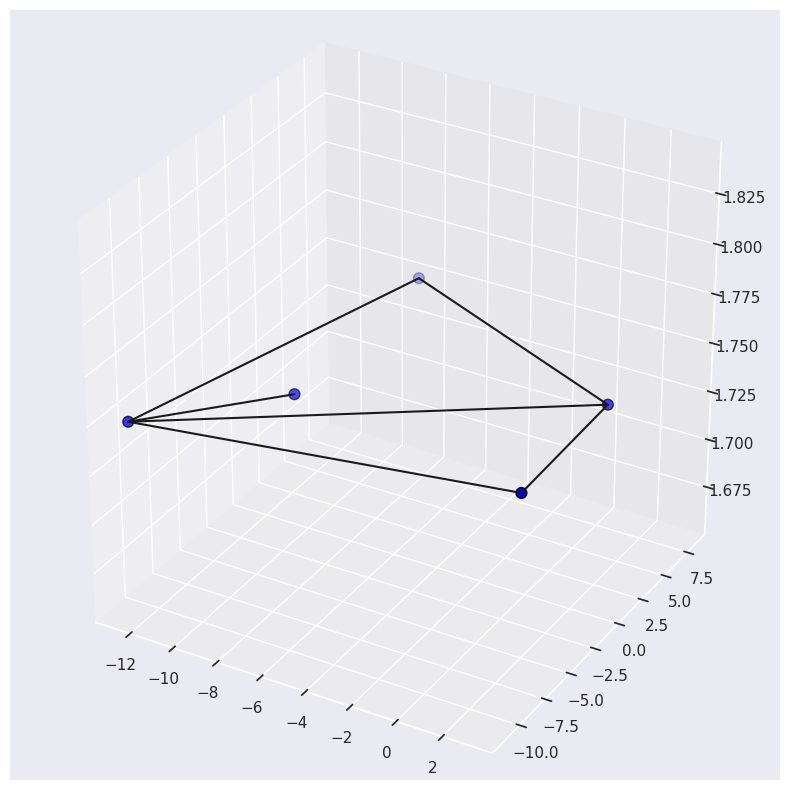

In [ ]:
fig = plt.figure(figsize=(20,10))

#Graph
ax = fig.add_subplot(1,1,1, projection="3d")
ax.set_box_aspect((1,1,1))

#draw nodes
ax.scatter(all_graphs_nodes[n]['x'],all_graphs_nodes[n]['y'],all_graphs_nodes[n]['z'], s=60 , c='blue',edgecolors='black')

#draw edges
for i in range(len(edges_pos)):
  ax.plot([edges_pos[i][0][0],edges_pos[i][1][0]],[edges_pos[i][0][1],edges_pos[i][1][1]] ,[edges_pos[i][0][2],edges_pos[i][1][2]],color='k')


**All the graphs**

In [32]:
fig = plt.figure(figsize=(100,100))

g_ind=1
for i,g,d in zip(all_graphs_nodes,Plan_graphs,graph_dataset):

  if d[1] == 0:
      graph_color='red'
  elif d[1] == 1:
      graph_color='orange'
  elif d[1] == 2:
      graph_color='green'
  elif d[1] == 3:
      graph_color='blue'

  edges_pos=[]

  for k in g.edges():
    first_node=k[0]
    second_node=k[1]
    edge_pos=[[i['x'][first_node],i['y'][first_node],i['z'][first_node]],[i['x'][second_node],i['y'][second_node],i['z'][second_node]]]
    edges_pos.append(edge_pos)

  #Graph
  ax = fig.add_subplot(13,15,g_ind, projection="3d") #This line will raise an error if the product of first and second number is less than the size of the dataset, but it will still plot the graphs till subplots are full
  ax.grid(False)
  ax.set_axis_off()
  ax.set_box_aspect((1,1,1))
  ax.set_title(f'Graph {g_ind-1}')

  #draw nodes
  ax.scatter(i['x'],i['y'],i['z'], s=60 , c=graph_color,edgecolors='black')

  #draw edges
  for l in range(len(edges_pos)):
    ax.plot([edges_pos[l][0][0],edges_pos[l][1][0]],[edges_pos[l][0][1],edges_pos[l][1][1]] ,[edges_pos[l][0][2],edges_pos[l][1][2]],color=graph_color)


  g_ind+=1


Output hidden; open in https://colab.research.google.com to view.

**Split the graphs list to Train / Validation/ Test**

In [34]:
import random

#train_graphs=random.sample(graph_dataset, k=110)
train_graphs=random.sample(graph_dataset, k=1420)
rest_of_graphs=[]
for i in graph_dataset:
  if i not in train_graphs:
    rest_of_graphs.append(i)

validation_graphs=random.sample(rest_of_graphs, k=280)

test_graphs=[]
for i in rest_of_graphs:
  if i not in validation_graphs:
    test_graphs.append(i)

print(f'Number of train graphs = { len(train_graphs)}' )
print(f'Number of valid graphs = { len(validation_graphs)}' )
print(f'Number of test graphs = { len(test_graphs)}' )


Number of train graphs = 1420
Number of valid graphs = 280
Number of test graphs = 200


**Convert to dgl graphs**

In [35]:
train_graphs_dgl=[]
for t_g,t_g_label in train_graphs:
  t_g_dgl=dgl.from_networkx(t_g, node_attrs=['x','y','z','RoomType','RoomQualit'])
  #########################################################
  #add edge attribures ('weight') ------------> please read the note after this cell
  weight_att=nx.get_edge_attributes(t_g,'weight')

  undirected_weight_att={}
  for i,j in zip(weight_att.keys(),weight_att.values()):
    original_key=i
    reverse_key=(i[1],i[0])   #the reverse edge will take same attribute

    undirected_weight_att[original_key] = j
    undirected_weight_att[reverse_key]  = j

  #add the edge weight to dgl
  #build a tensor of the attributes, the tensor must have the same order as dgl graph edges
  src_indicies=t_g_dgl.edges()[0]    #two tensors of source and destination indicies
  dis_indicies=t_g_dgl.edges()[1]
  weight_tensor_for_dgl=[]
  for src_index, dis_index in zip(src_indicies,dis_indicies):
    for k,v in zip(undirected_weight_att.keys() , undirected_weight_att.values() ):
      if k[0]==src_index and k[1]==dis_index:
        weight_tensor_for_dgl.append(v)

  weight_tensor_for_dgl=torch.tensor(weight_tensor_for_dgl)
  t_g_dgl.edata['weight'] = weight_tensor_for_dgl

  #########################################################
  #add all node features to one tensor "attr"
  t_g_dgl.ndata["x"]=torch.reshape(t_g_dgl.ndata["x"],(t_g_dgl.ndata["x"].shape[0],1))
  t_g_dgl.ndata["y"]=torch.reshape(t_g_dgl.ndata["y"],(t_g_dgl.ndata["y"].shape[0],1))
  t_g_dgl.ndata["z"]=torch.reshape(t_g_dgl.ndata["z"],(t_g_dgl.ndata["z"].shape[0],1))
  t_g_dgl.ndata["RoomType"]=torch.reshape(t_g_dgl.ndata["RoomType"],(t_g_dgl.ndata["RoomType"].shape[0],1))
  t_g_dgl.ndata["RoomQualit"]=torch.reshape(t_g_dgl.ndata["RoomQualit"],(t_g_dgl.ndata["RoomQualit"].shape[0],1))
  t_g_dgl.ndata["attr"]=torch.cat([t_g_dgl.ndata["RoomType"], t_g_dgl.ndata["RoomQualit"] ],1)
  t_g_dgl.ndata["attr"]=t_g_dgl.ndata["attr"].type(torch.float32)
  #########################################################


  train_graphs_dgl.append((t_g_dgl,t_g_label))

validation_graphs_dgl=[]
for v_g,v_g_label in validation_graphs:
  v_g_dgl=dgl.from_networkx(v_g, node_attrs=['x','y','z','RoomType','RoomQualit'])
  #########################################################
  #add edge attribures ('weight') ------------> please read the note after this cell
  weight_att=nx.get_edge_attributes(v_g,'weight')

  undirected_weight_att={}
  for i,j in zip(weight_att.keys(),weight_att.values()):
    original_key=i
    reverse_key=(i[1],i[0])   #the reverse edge will take same attribute

    undirected_weight_att[original_key] = j
    undirected_weight_att[reverse_key]  = j

  #add the edge weight to dgl
  #build a tensor of the attributes, the tensor must have the same order as dgl graph edges
  src_indicies=v_g_dgl.edges()[0]    #two tensors of source and destination indicies
  dis_indicies=v_g_dgl.edges()[1]
  weight_tensor_for_dgl=[]
  for src_index, dis_index in zip(src_indicies,dis_indicies):
    for k,v in zip(undirected_weight_att.keys() , undirected_weight_att.values() ):
      if k[0]==src_index and k[1]==dis_index:
        weight_tensor_for_dgl.append(v)

  weight_tensor_for_dgl=torch.tensor(weight_tensor_for_dgl)
  v_g_dgl.edata['weight'] = weight_tensor_for_dgl

  #########################################################
  #add all node features to one tensor "attr"
  v_g_dgl.ndata["x"]=torch.reshape(v_g_dgl.ndata["x"],(v_g_dgl.ndata["x"].shape[0],1))
  v_g_dgl.ndata["y"]=torch.reshape(v_g_dgl.ndata["y"],(v_g_dgl.ndata["y"].shape[0],1))
  v_g_dgl.ndata["z"]=torch.reshape(v_g_dgl.ndata["z"],(v_g_dgl.ndata["z"].shape[0],1))
  v_g_dgl.ndata["RoomType"]=torch.reshape(v_g_dgl.ndata["RoomType"],(v_g_dgl.ndata["RoomType"].shape[0],1))
  v_g_dgl.ndata["RoomQualit"]=torch.reshape(v_g_dgl.ndata["RoomQualit"],(v_g_dgl.ndata["RoomQualit"].shape[0],1))
  v_g_dgl.ndata["attr"]=torch.cat([v_g_dgl.ndata["RoomType"], v_g_dgl.ndata["RoomQualit"] ],1)
  v_g_dgl.ndata["attr"]=v_g_dgl.ndata["attr"].type(torch.float32)
  #########################################################

  validation_graphs_dgl.append((v_g_dgl,v_g_label))

test_graphs_dgl=[]
for te_g,te_g_label in test_graphs:
  te_g_dgl=dgl.from_networkx(te_g, node_attrs=['x','y','z','RoomType','RoomQualit'])
  #########################################################
  #add edge attribures ('weight') ------------> please read the note after this cell
  weight_att=nx.get_edge_attributes(te_g,'weight')

  undirected_weight_att={}
  for i,j in zip(weight_att.keys(),weight_att.values()):
    original_key=i
    reverse_key=(i[1],i[0])   #the reverse edge will take same attribute

    undirected_weight_att[original_key] = j
    undirected_weight_att[reverse_key]  = j

  #add the edge weight to dgl
  #build a tensor of the attributes, the tensor must have the same order as dgl graph edges
  src_indicies=te_g_dgl.edges()[0]    #two tensors of source and destination indicies
  dis_indicies=te_g_dgl.edges()[1]
  weight_tensor_for_dgl=[]
  for src_index, dis_index in zip(src_indicies,dis_indicies):
    for k,v in zip(undirected_weight_att.keys() , undirected_weight_att.values() ):
      if k[0]==src_index and k[1]==dis_index:
        weight_tensor_for_dgl.append(v)

  weight_tensor_for_dgl=torch.tensor(weight_tensor_for_dgl)
  te_g_dgl.edata['weight'] = weight_tensor_for_dgl

  #########################################################
  #add all node features to one tensor "attr"
  te_g_dgl.ndata["x"]=torch.reshape(te_g_dgl.ndata["x"],(te_g_dgl.ndata["x"].shape[0],1))
  te_g_dgl.ndata["y"]=torch.reshape(te_g_dgl.ndata["y"],(te_g_dgl.ndata["y"].shape[0],1))
  te_g_dgl.ndata["z"]=torch.reshape(te_g_dgl.ndata["z"],(te_g_dgl.ndata["z"].shape[0],1))
  te_g_dgl.ndata["RoomType"]=torch.reshape(te_g_dgl.ndata["RoomType"],(te_g_dgl.ndata["RoomType"].shape[0],1))
  te_g_dgl.ndata["RoomQualit"]=torch.reshape(te_g_dgl.ndata["RoomQualit"],(te_g_dgl.ndata["RoomQualit"].shape[0],1))
  te_g_dgl.ndata["attr"]=torch.cat([te_g_dgl.ndata["RoomType"], te_g_dgl.ndata["RoomQualit"] ],1)
  te_g_dgl.ndata["attr"]=te_g_dgl.ndata["attr"].type(torch.float32)
  #########################################################

  test_graphs_dgl.append((te_g_dgl,te_g_label))

 ↕ ↕ ↕ **Add edge weight** ↕ ↕ ↕

In dgl, if we are getting a dgl graph from an undirected nx graph, **we can not add edge attributes directly as we did with node attributes**.
This is because dgl graphs are always directed - that's why it dobles number of edges in nx- and so it will avoid adding edge features, since we have now the edge and its reverse. The way to add the edge features then is to add them to the graph after being converted to dgl.

In [36]:
t_g.number_of_edges()

11

In [37]:
t_g_dgl.num_edges()

22

**Visualize each set of graphs (Training , Test, Validation)**

In [ ]:
# fig = plt.figure(figsize=(100,100))

# #Train Graphs
# g_ind=1
# for g,g_label in (train_graphs):

#   if g_label == 0:
#       graph_color='red'
#   elif g_label == 1:
#       graph_color='blue'
#   elif g_label == 2:
#       graph_color='green'
#   elif g_label == 3:
#       graph_color='orange'
#   elif g_label == 4:
#       graph_color='yellow'
#   edges_pos=[]

#   for k in g.edges():
#     first_node=k[0]
#     second_node=k[1]
#     edge_pos=[[nx.get_node_attributes(g,'x')[first_node],nx.get_node_attributes(g,'y')[first_node],nx.get_node_attributes(g,'z')[first_node]],[nx.get_node_attributes(g,'x')[second_node],nx.get_node_attributes(g,'y')[second_node],nx.get_node_attributes(g,'z')[second_node]]]
#     edges_pos.append(edge_pos)

#   #Graph
#   ax = fig.add_subplot(300,10,g_ind, projection="3d")
#   ax.grid(False)
#   ax.set_axis_off()
#   ax.set_box_aspect((1,1,1))
#   ax.set_title(f'Train graph {g_ind-1}')

#   #draw nodes
#   ax.scatter(nx.get_node_attributes(g,'x').values(),nx.get_node_attributes(g,'y').values(),nx.get_node_attributes(g,'z').values(), s=60 , c=graph_color,edgecolors='black')

#   #draw edges
#   for l in range(len(edges_pos)):
#     ax.plot([edges_pos[l][0][0],edges_pos[l][1][0]],[edges_pos[l][0][1],edges_pos[l][1][1]] ,[edges_pos[l][0][2],edges_pos[l][1][2]],color=graph_color)

#   g_ind+=1


---

In [ ]:
# #Validation Graphs
# fig = plt.figure(figsize=(30,5))
# g_ind=1
# for g,g_label in (validation_graphs):

#   if g_label == 0:
#       graph_color='red'
#   elif g_label == 1:
#       graph_color='blue'
#   elif g_label == 2:
#       graph_color='green'
#   elif g_label == 3:
#       graph_color='orange'
#   elif g_label == 4:
#       graph_color='yellow'
#   edges_pos=[]

#   for k in g.edges():
#     first_node=k[0]
#     second_node=k[1]
#     edge_pos=[[nx.get_node_attributes(g,'x')[first_node],nx.get_node_attributes(g,'y')[first_node],nx.get_node_attributes(g,'z')[first_node]],[nx.get_node_attributes(g,'x')[second_node],nx.get_node_attributes(g,'y')[second_node],nx.get_node_attributes(g,'z')[second_node]]]
#     edges_pos.append(edge_pos)

#   #Graph
#   ax = fig.add_subplot(5,35,g_ind, projection="3d")
#   ax.grid(False)
#   ax.set_axis_off()
#   ax.set_box_aspect((1,1,1))
#   ax.set_title(f'Validation graph {g_ind-1}')

#   #draw nodes
#   ax.scatter(nx.get_node_attributes(g,'x').values(),nx.get_node_attributes(g,'y').values(),nx.get_node_attributes(g,'z').values(), s=10 , c=graph_color,edgecolors='black')

#   #draw edges
#   for l in range(len(edges_pos)):
#     ax.plot([edges_pos[l][0][0],edges_pos[l][1][0]],[edges_pos[l][0][1],edges_pos[l][1][1]] ,[edges_pos[l][0][2],edges_pos[l][1][2]],color=graph_color)

#   g_ind+=1

In [41]:
#Test Graphs
fig = plt.figure(figsize=(100,100))
g_ind=1
for g,g_label in (test_graphs):

  if g_label == 0:
      graph_color='red'
  elif g_label == 1:
      graph_color='orange'
  elif g_label == 2:
      graph_color='green'
  elif g_label == 3:
      graph_color='blue'

  edges_pos=[]

  for k in g.edges():
    first_node=k[0]
    second_node=k[1]
    edge_pos=[[nx.get_node_attributes(g,'x')[first_node],nx.get_node_attributes(g,'y')[first_node],nx.get_node_attributes(g,'z')[first_node]],[nx.get_node_attributes(g,'x')[second_node],nx.get_node_attributes(g,'y')[second_node],nx.get_node_attributes(g,'z')[second_node]]]
    edges_pos.append(edge_pos)

  #Graph
  ax = fig.add_subplot(15,15,g_ind, projection="3d")
  ax.grid(False)
  ax.set_axis_off()
  ax.set_box_aspect((2,2,2))
  ax.set_title(f'Test graph {g_ind-1}')

  #draw nodes
  ax.scatter(nx.get_node_attributes(g,'x').values(),nx.get_node_attributes(g,'y').values(),nx.get_node_attributes(g,'z').values(), s=10 , c=graph_color,edgecolors='black')

  #draw edges
  for l in range(len(edges_pos)):
    ax.plot([edges_pos[l][0][0],edges_pos[l][1][0]],[edges_pos[l][0][1],edges_pos[l][1][1]] ,[edges_pos[l][0][2],edges_pos[l][1][2]],color=graph_color)

  g_ind+=1

Output hidden; open in https://colab.research.google.com to view.

#####**Learning**

**Define the classifier model**

In [42]:
class SAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(SAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats,'mean')
        self.conv2 = SAGEConv(h_feats, num_classes,'mean')

    def forward(self, g, in_feat,edge_weight):  #edge_weight to include edge weight in the meassage passing, pass the weights tensor here
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")

**Define the graph dataloader**

mini-batches of graphs

Each item in the graph classification dataset is a pair of a graph and its label. One can speed up the data loading process by taking advantage of the GraphDataLoader to iterate over the dataset of graphs in mini-batches.

In [43]:
dataset=train_graphs_dgl

train_dataloader = GraphDataLoader(
    dataset,
    batch_size=32,
    drop_last=False,
    shuffle=True)

In [44]:
for batched_graph, labels in train_dataloader:
  pass
  #-----check-----
  print(batched_graph)
  print(labels)  #110/8 ----> 14 batches of graphs

Graph(num_nodes=214, num_edges=542,
      ndata_schemes={'x': Scheme(shape=(1,), dtype=torch.float64), 'y': Scheme(shape=(1,), dtype=torch.float64), 'z': Scheme(shape=(1,), dtype=torch.float64), 'RoomType': Scheme(shape=(1,), dtype=torch.int64), 'RoomQualit': Scheme(shape=(1,), dtype=torch.float64), 'attr': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})
tensor([1., 3., 3., 2., 1., 2., 0., 1., 3., 1., 0., 1., 3., 0., 0., 2., 0., 3.,
        1., 0., 0., 3., 1., 0., 0., 2., 0., 1., 3., 0., 0., 2.],
       dtype=torch.float64)
Graph(num_nodes=207, num_edges=528,
      ndata_schemes={'x': Scheme(shape=(1,), dtype=torch.float64), 'y': Scheme(shape=(1,), dtype=torch.float64), 'z': Scheme(shape=(1,), dtype=torch.float64), 'RoomType': Scheme(shape=(1,), dtype=torch.int64), 'RoomQualit': Scheme(shape=(1,), dtype=torch.float64), 'attr': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=to

**Inference function for validation and test graphs**

In [45]:
def evaluate(dataset, device, model):
    model.eval()
    total = 0
    total_correct = 0

    all_labels=[]
    all_predicted=[]
    with torch.no_grad():
      for graph, label in dataset:
          graph = graph.to(device)

          feat = graph.ndata.pop("attr")
          #edge weights -if any-
          e_weights=graph.edata['weight']

          total += 1
          logits = model(graph, feat,e_weights)

          _, predicted = torch.max(logits, 1)  #argmax
          total_correct += (predicted == label).sum().item()

          #for visualization
          all_labels.append(label)
          all_predicted.append(predicted.item())

    acc = 1.0 * total_correct / total
    return acc , all_labels , all_predicted


**Training**

In [46]:
n_epochs=1000
lr=0.01
n_classes=4
n_features=train_graphs_dgl[0][0].ndata['attr'].shape[1]
n_hidden=8
device='cpu'

In [47]:
model = SAGE(n_features, n_hidden, n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses=[]
valid_acc=[]
for epoch in range(n_epochs):
    model.train()
    for batched_graph, labels in train_dataloader:
        labels=labels.long()
        feats = batched_graph.ndata['attr']
        e_weights=batched_graph.edata['weight']  #if you have edge weights
        logits = model(batched_graph, feats,e_weights)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    #validation
    validation_acc =evaluate(validation_graphs_dgl,device,model)[0]
    valid_acc.append(validation_acc)
    print(f'epoch {epoch} | loss {loss.item()} | validation accuracy {validation_acc}')

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


epoch 0 | loss 1.3063443899154663 | validation accuracy 0.14642857142857144
epoch 1 | loss 1.289162278175354 | validation accuracy 0.30357142857142855
epoch 2 | loss 1.1919236183166504 | validation accuracy 0.4785714285714286
epoch 3 | loss 1.1256368160247803 | validation accuracy 0.5535714285714286
epoch 4 | loss 1.0549476146697998 | validation accuracy 0.6214285714285714
epoch 5 | loss 0.9177319407463074 | validation accuracy 0.6285714285714286
epoch 6 | loss 1.1829192638397217 | validation accuracy 0.6535714285714286
epoch 7 | loss 1.0137273073196411 | validation accuracy 0.6285714285714286
epoch 8 | loss 0.8583870530128479 | validation accuracy 0.675
epoch 9 | loss 0.6250380873680115 | validation accuracy 0.6678571428571428
epoch 10 | loss 0.8784763216972351 | validation accuracy 0.7107142857142857
epoch 11 | loss 0.6803705096244812 | validation accuracy 0.7321428571428571
epoch 12 | loss 0.686726987361908 | validation accuracy 0.7285714285714285
epoch 13 | loss 0.5782471299171448 

---

#####**Evaluation**

**Training Loss**

Text(0.5, 1.0, 'Training Loss')

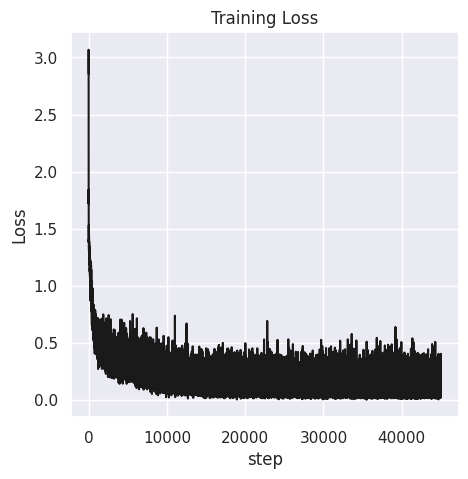

In [48]:
plt.figure(figsize=(5,5))
plt.plot(range(len(losses)), losses, "k")
plt.xlabel('step')
plt.ylabel('Loss')
plt.title('Training Loss')

**Validation Accuracy**

Text(0.5, 1.0, 'Validation Accuracy')

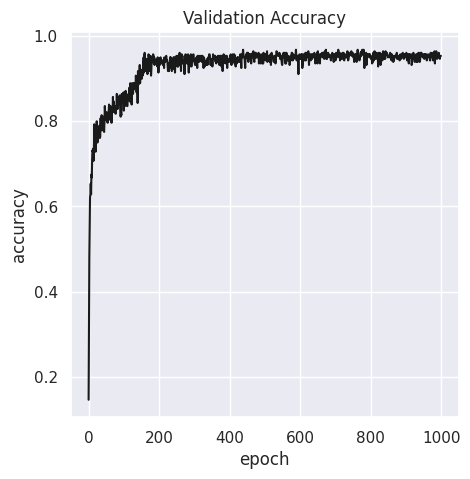

In [49]:
plt.figure(figsize=(5,5))
plt.plot(range(len(valid_acc)), valid_acc, "k")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy')

**Test**

In [50]:
test_acc , test_labels, test_predictions =evaluate(test_graphs_dgl,device,model)

In [51]:
print(test_acc)
print(test_labels)
print(test_predictions)

0.935
[1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 3.0, 2.0, 1.0, 0.0, 0.0, 1.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0, 3.0, 2.0, 1.0, 3.0, 1.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0.0, 3.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 1.0, 2.0, 2.0, 3.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 3.0, 0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0.0, 3.0, 0.0, 3.0, 3.0, 0.0, 3.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 3.0, 0.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 0.0, 3.0, 0.0, 0.0, 3.0, 3.0, 0.0, 3.0

**Visualization**

In [52]:
#Test Graphs
fig = plt.figure(figsize=(100,100))
g_ind=1
plot_ind=0
for g,g_label in (test_graphs):

  #true colors
  if g_label == 0:
      graph_color='red'
  elif g_label == 1:
      graph_color='orange'
  elif g_label == 2:
      graph_color='green'
  elif g_label == 3:
      graph_color='blue'

  edges_pos=[]

  for k in g.edges():
    first_node=k[0]
    second_node=k[1]
    edge_pos=[[nx.get_node_attributes(g,'x')[first_node],nx.get_node_attributes(g,'y')[first_node],nx.get_node_attributes(g,'z')[first_node]],[nx.get_node_attributes(g,'x')[second_node],nx.get_node_attributes(g,'y')[second_node],nx.get_node_attributes(g,'z')[second_node]]]
    edges_pos.append(edge_pos)

  #Graph with true labels
  ax = fig.add_subplot(30,15,g_ind, projection="3d")
  ax.grid(False)
  ax.set_axis_off()
  ax.set_box_aspect((1,1,1))
  ax.set_title(f'Test Graph Ground Truth {plot_ind}')

  #draw nodes
  ax.scatter(nx.get_node_attributes(g,'x').values(),nx.get_node_attributes(g,'y').values(),nx.get_node_attributes(g,'z').values(), s=10 , c=graph_color,edgecolors='black')

  #draw edges
  for l in range(len(edges_pos)):
    ax.plot([edges_pos[l][0][0],edges_pos[l][1][0]],[edges_pos[l][0][1],edges_pos[l][1][1]] ,[edges_pos[l][0][2],edges_pos[l][1][2]],color=graph_color)



  #Graph with predicted labels
  ax = fig.add_subplot(30,15,g_ind+1, projection="3d")
  ax.grid(False)
  ax.set_axis_off()
  ax.set_box_aspect((1,1,1))
  ax.set_title(f'Test Graph Prediction {plot_ind}')

  #predicted colors
  if test_predictions[plot_ind] == 0:
      p_graph_color='red'
  elif test_predictions[plot_ind] == 1:
      p_graph_color='orange'
  elif test_predictions[plot_ind] == 2:
      p_graph_color='green'
  elif test_predictions[plot_ind] == 3:
      p_graph_color='blue'

  #draw nodes
  ax.scatter(nx.get_node_attributes(g,'x').values(),nx.get_node_attributes(g,'y').values(),nx.get_node_attributes(g,'z').values(), s=10 , c=p_graph_color,edgecolors='black')

  #draw edges
  for l in range(len(edges_pos)):
    ax.plot([edges_pos[l][0][0],edges_pos[l][1][0]],[edges_pos[l][0][1],edges_pos[l][1][1]] ,[edges_pos[l][0][2],edges_pos[l][1][2]],color=p_graph_color)

  g_ind+=2
  plot_ind+=1

Output hidden; open in https://colab.research.google.com to view.

**Confusion matrix**

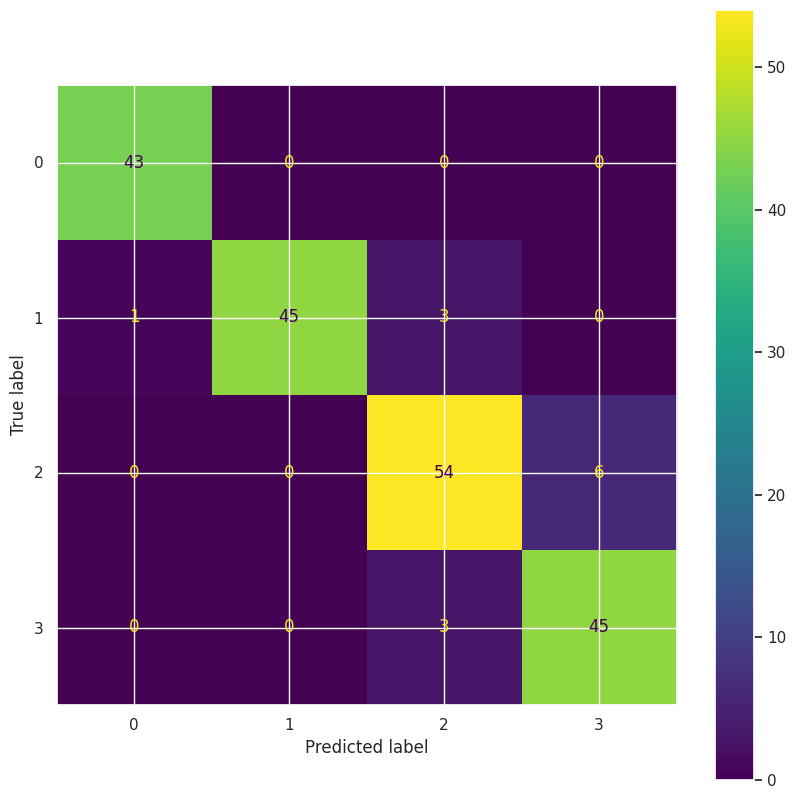

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = test_predictions
cm = confusion_matrix(test_labels, predictions, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2,3])
disp.plot()
plt.show()

---

▶ General note: when using the model for predictiong, make sure the order of the nodes features you give is the same order the model was trained on.

#####**Prediction (save and load the model)**

**Save**

In [ ]:
model_path="self_shade_classifier"
torch.save(model.state_dict(), model_path)

**Load**

In [ ]:
loaded_model=SAGE( in_feats=5, h_feats=300, num_classes=3)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

---